In [19]:
from data import ConnectionString
from IPython.core.interactiveshell import InteractiveShell

import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from urllib.parse import quote_plus
import numpy as np
import seaborn as sns

In [11]:
conn_str_builder = ConnectionString()
conn_str = conn_str_builder.setup_connection_string()
params = quote_plus(conn_str)
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

try:
    df = pd.read_sql("SELECT * FROM dbo.AttendanceData", engine)

except Exception as e:
    print(f"Unable to Connect to SQL Server: {e}")

In [3]:
df.info()
InteractiveShell.ast_node_interactivity = 'all' # type: ignore

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2027982 entries, 0 to 2027981
Data columns (total 17 columns):
 #   Column                       Dtype 
---  ------                       ----- 
 0   SCHOOL_YEAR                  object
 1   DISTRICT_CODE                object
 2   DISTRICT_NAME                object
 3   LOCATION_ID                  object
 4   SCHOOL_NAME                  object
 5   STUDENT_ID                   object
 6   Total_Days_Unexcused_Absent  object
 7   Total_Days_Enrolled          object
 8   Total_Days_Present           object
 9   STUDENT_GRADE_LEVEL          object
 10  CURR_GRADE_ORD               object
 11  ETHNIC_CODE                  object
 12  STUDENT_GENDER               object
 13  ECONOMIC_CODE                object
 14  SPECIAL_ED_CODE              object
 15  ENG_PROF_CODE                object
 16  HISPANIC_IND                 object
dtypes: object(17)
memory usage: 263.0+ MB


In [12]:
df = df.drop('CURR_GRADE_ORD', axis=1)
df['SCHOOL_YEAR'] = df['SCHOOL_YEAR'].str.split('-').str[0]
df['STUDENT_GRADE_LEVEL'] = df['STUDENT_GRADE_LEVEL'].replace(['PK', 'KF', 'OS'], [-1, 0, -2])
df['ECONOMIC_CODE'] = df['ECONOMIC_CODE'].replace(['F', 'N', 'R'], [1, 0, 1])
df['SPECIAL_ED_CODE'] = df['SPECIAL_ED_CODE'].replace(['Y', 'N'], [1, 0])
df['ENG_PROF_CODE'] = df['ENG_PROF_CODE'].replace('NT', -1)
df['HISPANIC_IND'] = df['HISPANIC_IND'].replace(['No', 'Yes'], [0, 1])

C:\Users\BVM11\AppData\Local\Temp\ipykernel_7968\2389374588.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ECONOMIC_CODE'] = df['ECONOMIC_CODE'].replace(['F', 'N', 'R'], [1, 0, 1])
C:\Users\BVM11\AppData\Local\Temp\ipykernel_7968\2389374588.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['SPECIAL_ED_CODE'] = df['SPECIAL_ED_CODE'].replace(['Y', 'N'], [1, 0])
C:\Users\BVM11\AppData\Local\Temp\ipykernel_7968\2389374588.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future

In [13]:
non_numeric_columns = ['SCHOOL_NAME', 'DISTRICT_NAME', 'ETHNIC_CODE', 'STUDENT_GENDER']
float_cols = ['Total_Days_Unexcused_Absent', 'Total_Days_Enrolled', 'Total_Days_Present']

numeric_columns = [col for col in df.columns if col not in [*non_numeric_columns, *float_cols]]

for col in numeric_columns:
    df[col] = df[col].astype(int)

for col in float_cols:
    df[col] = df[col].astype(float)

In [ ]:
# df.loc[1688836, 'Total_Days_Present'] = 54.0
# df.loc[731523, 'Total_Days_Present'] = 1.0
# df.loc[1904340, 'Total_Days_Present'] = 2.0
# df.loc[1904340, 'Total_Days_Unexcused_Absent'] = 8.0
# df.loc[1904340, 'Total_Days_Enrolled'] = 10.0
# df.loc[[1016188, 1227776, 1400304, 1401473, 1413193], 'Total_Days_Unexcused_Absent'] = 0.0
# df.loc[686159, 'Total_Days_Unexcused_Absent'] = 3.5
# df.loc[687907, 'Total_Days_Unexcused_Absent'] = 4.0

In [ ]:
#12-th grade students
grade_12_students = df[df['STUDENT_GRADE_LEVEL'] == 12]

# Days Enrolled Greater than Unexcused + Present
days_enr_gt_unexcpluspres = df[(df['Total_Days_Unexcused_Absent'] + df['Total_Days_Present']) > df['Total_Days_Enrolled']]

# Grade inconsistencies (demotion of grades)
df_sorted = df.sort_values(by=['STUDENT_ID', 'SCHOOL_YEAR'])
grade_mask = df_sorted.groupby('STUDENT_ID')['STUDENT_GRADE_LEVEL'].diff().lt(0)
grade_inconsitency_df = df[df['STUDENT_ID'].isin(df[grade_mask]['STUDENT_ID'].values)].sort_values(by='STUDENT_ID')

# Drop list
negative_values_indices = [1688836, 731523, 1904340, *[1016188, 1227776, 1400304, 1401473, 1413193], 686159, 687907]
drop_list = [*days_enr_gt_unexcpluspres.index, *grade_inconsitency_df.index, *grade_12_students.index, *negative_values_indices]

df.drop(drop_list, ind)

C:\Users\BVM11\AppData\Local\Temp\ipykernel_7968\2825459957.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grade_inconsitency_df = df[df['STUDENT_ID'].isin(df[grade_mask]['STUDENT_ID'].values)].sort_values(by='STUDENT_ID')


In [9]:
mask = df.groupby('STUDENT_ID')['STUDENT_GENDER'].transform('nunique').gt(1)
gender_change_df = df[mask].sort_values(by=['STUDENT_ID', 'SCHOOL_YEAR'])
gender_change_df['STUDENT_GENDER'] = gender_change_df.groupby('STUDENT_ID')['STUDENT_GENDER'].transform('last')

df = df.drop(gender_change_df.index, axis=0)
df = pd.concat([df, gender_change_df], axis=0).reset_index(drop=True)

In [17]:
df['Attendance_Rate'] = df['Total_Days_Present'] / df['Total_Days_Enrolled']

<Axes: xlabel='Attendance_Rate', ylabel='Count'>

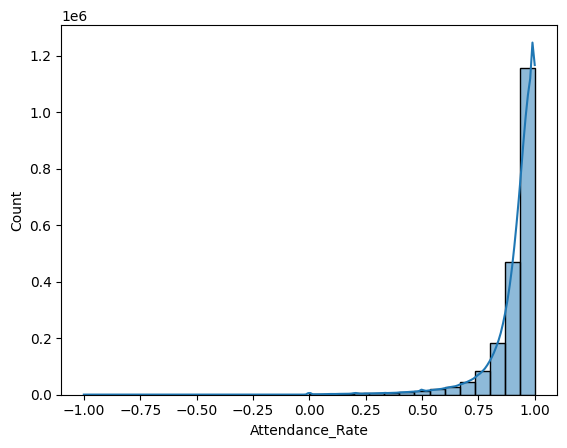

In [20]:
sns.histplot(df['Attendance_Rate'], bins=30, kde=True)